### 基礎からのベイズ統計学 (豊田秀樹著)

Pythonとpystanによるstanの実行デモ

In [1]:
from __future__ import division
import math, sys
import numpy as np
import numpy.random as rd
import pandas as pd
from datetime import  datetime as dt
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import pystan
from pystan import StanModel

sns.set(style="whitegrid", palette="muted", color_codes=True)

In [2]:
print(sys.version)

3.5.1 |Anaconda 2.5.0 (64-bit)| (default, Dec  7 2015, 11:16:01) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [59]:
def plot_result(disp_param, la):
    n_param = len(disp_param)
    f, axes = plt.subplots(n_param, 2, figsize=(15, 4*n_param))
    cnt = 0
    for name in disp_param:
        dat = la[name]
        if dat.ndim == 2:
            for j in range(dat.shape[1]):
                d = dat[:,j]
                sns.distplot(d, hist=False, rug=True, ax=axes[cnt, 0])
                sns.tsplot(d,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
                cnt += 1
        else:
            # Intercept
            sns.distplot(dat, hist=False, rug=True, ax=axes[cnt, 0])
            sns.tsplot(dat,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
            cnt += 1

    name_list = []
    for name in disp_param:
        if la[name].ndim == 2:
            for i in range(dat.shape[1]):
                name_list.append("{}{}".format(name,i+1))
        else:
            name_list.append(name)

    for i in range(2):
        for j, t in enumerate(name_list):
            axes[j, i].set_title(t)
    plt.show()

### 8.1 比率を用いた推測（比率の差・リスク比・オッズ比）

In [182]:
# データのセット
N = [200,200]
n = [[128,72],
     [97,103]]

data = {"N":N, "n":n}

In [183]:
# Stanコード
stan_code = u"""
data{
    int<lower=0> N[2];
    int n[2,2];
}
parameters{
    simplex[2] p[2];
}
model{
    for(i in 1:2){
        for(j in 1:2){
            n[i,j] ~ binomial(N[j], p[j][i]);
        }
    }
}
generated quantities{
    real d;
    real delta_over;
    real p11;
    real p10;
    real p01;
    real p00;
    real RR;
    real OR;
    p11 <- p[1][1];
    p10 <- p[1][2];
    p01 <- p[2][1];
    p00 <- p[2][2];

    d <- p11 - p01;                     # difference of ratio
    delta_over <- if_else(d > 0,1,0);
    RR <- p11/p01;                      # risk ratio
    OR <- (p11/p10) / (p01/p00);        # odds ratio
}
"""

In [184]:
# モデルのコンパイル
%time stm = StanModel(model_code=stan_code)

CPU times: user 1.68 s, sys: 2.94 s, total: 4.62 s
Wall time: 1min


In [185]:

n_itr    = 11000   # サンプル数
n_warmup = 1000    # バーンイン期間
chains   = 1       # チェーンの数
seed     = 71      # 乱数のシード

# サンプリングの実行
%time fit = stm.sampling(data=data, iter=n_itr, chains=chains, n_jobs=-1, seed=seed, warmup=n_warmup, algorithm="NUTS", verbose=False)


CPU times: user 240 ms, sys: 8 ms, total: 248 ms
Wall time: 245 ms


In [186]:
la    = fit.extract(permuted=True)  # return a dictionary of arrays
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])
print(fit)

Inference for Stan model: anon_model_a86f4ccd3c24b5b67fe6ec80d5782b69.
1 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p[0,0]       0.58  5.0e-4   0.02   0.53   0.56   0.58   0.59   0.63   2429    1.0
p[1,0]       0.42  4.9e-4   0.03   0.37   0.41   0.42   0.44   0.47   2557    1.0
p[0,1]       0.42  5.0e-4   0.02   0.37   0.41   0.42   0.44   0.47   2429    1.0
p[1,1]       0.58  4.9e-4   0.03   0.53   0.56   0.58   0.59   0.63   2557    1.0
d            0.15  7.0e-4   0.04   0.08   0.13   0.15   0.18   0.22   2513    1.0
delta_over    1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0  10000    nan
p11          0.58  5.0e-4   0.02   0.53   0.56   0.58   0.59   0.63   2429    1.0
p10          0.42  5.0e-4   0.02   0.37   0.41   0.42   0.44   0.47   2429    1.0
p01          0.42  4.9e-4   0.03   0.37   0.41   0.42   0.44   0.47   

In [187]:
pd.DataFrame(fit.get_posterior_mean(), index=fit.flatnames+["lp__"], columns=["EAP"])


,EAP
"p[0,0]",0.577203
"p[1,0]",0.422757
"p[0,1]",0.422797
"p[1,1]",0.577243
d,0.154447
delta_over,1.000000
p11,0.577203
p10,0.422797
p01,0.422757
p00,0.577243


/mnt/workspace/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


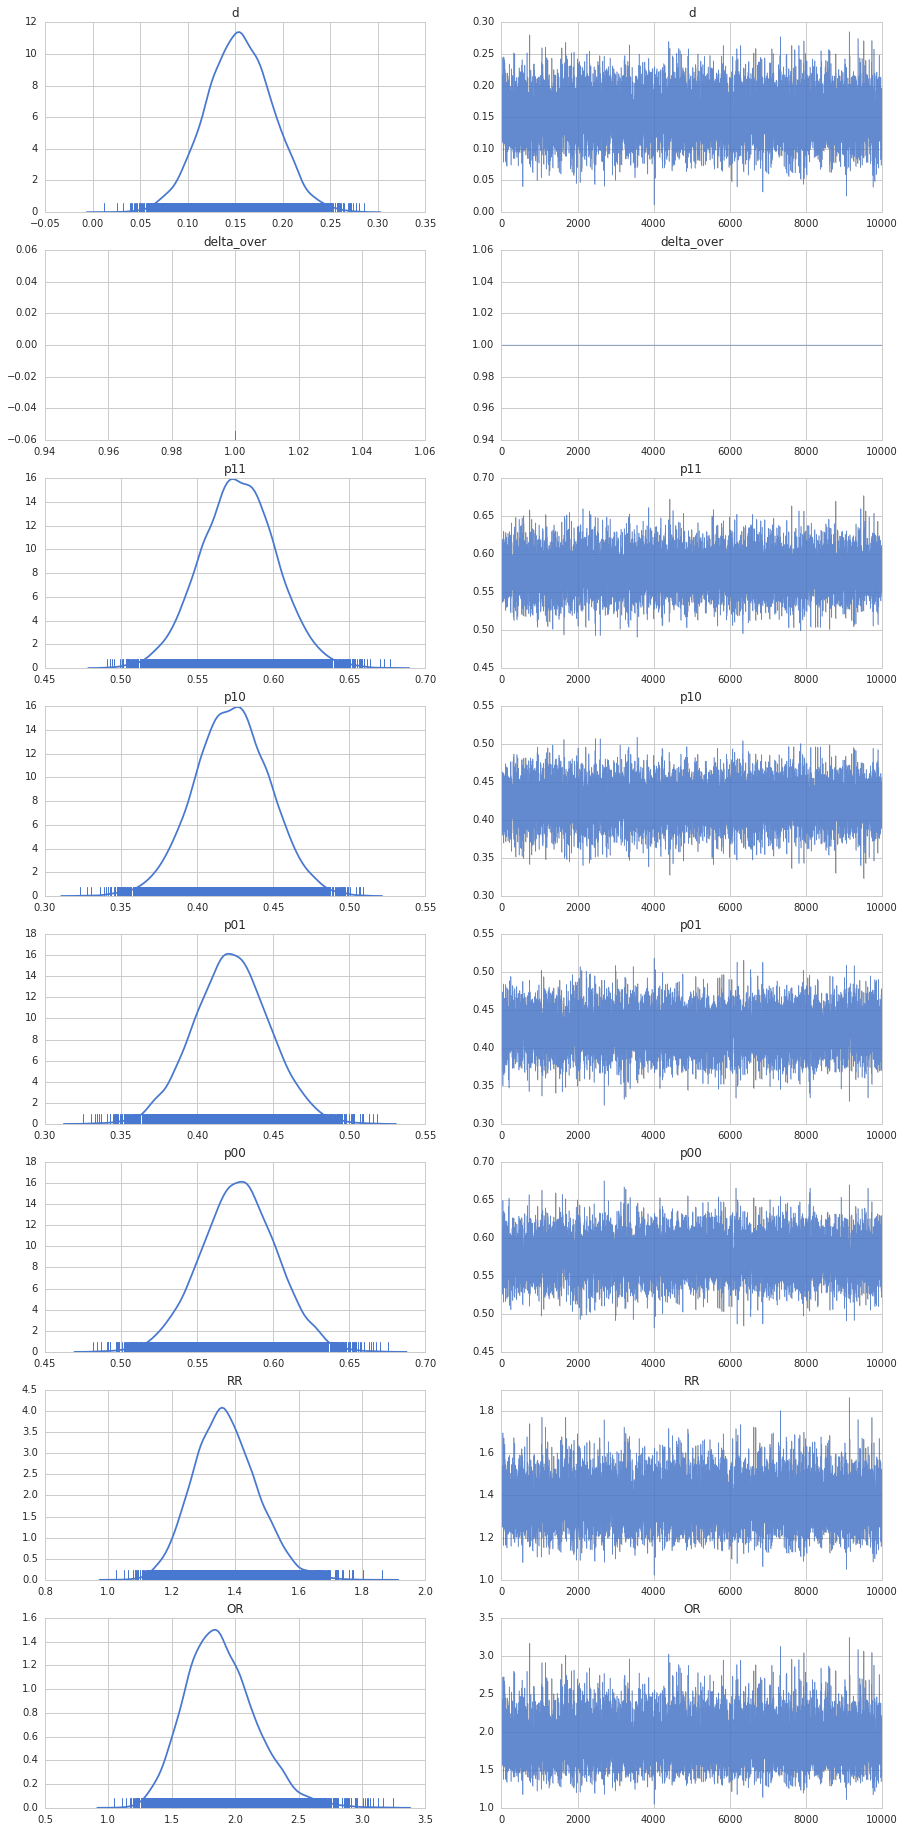

CPU times: user 4min 29s, sys: 10.2 s, total: 4min 39s
Wall time: 4min 39s


In [188]:
disp_param = ['d', 'delta_over', 'p11', 'p10', 'p01', 'p00', 'RR', 'OR']
%time plot_result(disp_param, la)

200

### 2群の相関係数の差に関する推測

In [26]:
# データのセット

N = 200
xA = np.array([
    [11,6,10,8,10,14,5,9,15,10,8,8,14,10,11,8,12,11,12,9,
    6,10,12,11,8,10,8,9,7,5,8,10,14,15,5,11,5,7,5,11,10,
    9,14,11,10,11,13,10,15,15,15,5,8,16,6,11,9,10,9,16,13,
    9,10,17,8,7,14,9,9,12,7,17,15,13,9,10,11,5,4,9,11,11,
    3,12,14,12,9,8,9,12,9,13,15,11,14,11,7,15,13,11,10,
    14,2,11,14,12,12,9,11,10,13,12,8,6,10,11,10,11,13,9,9,
    12,13,9,12,11,11,13,13,10,17,8,11,8,9,13,6,17,9,14,11,
    10,7,13,13,8,9,9,7,9,8,11,14,9,8,10,8,8,2,8,5,9,10,8,17,
    7,11,8,10,7,8,12,9,11,6,11,5,12,9,7,14,9,10,7,5,12,6,11,
    10,9,6,7,11,4,12,9,14,9,4,12],
    [12,10,12,10,10,14,9,11,14,9,9,9,13,13,13,10,13,10,13,11,
     10,11,10,12,9,8,10,11,12,8,11,6,9,12,9,15,10,11,10,15,12,
     11,12,12,13,10,13,9,14,13,14,6,11,14,8,10,9,8,10,12,12,8,
     13,15,9,9,13,13,7,14,5,14,13,12,13,12,12,10,8,12,12,13,9,
     11,10,13,13,11,10,10,8,13,13,9,12,14,7,14,11,10,13,15,9,
     10,14,11,11,11,12,10,12,15,13,12,13,11,10,11,14,11,9,14,
     15,9,9,10,13,13,15,14,14,9,11,11,11,13,10,13,9,13,11,13,
     10,12,13,8,9,12,11,10,12,13,12,11,11,12,9,11,9,9,11,9,10,
     11,13,10,12,8,9,9,12,10,12,9,10,12,8,11,9,9,13,9,10,10,9,
     11,8,13,9,12,10,9,9,6,12,10,12,8,10,12]])
xB = np.array([
    [16,12,13,15,10,16,10,12,12,16,15,15,14,13,9,12,10,10,16,15,
     12,15,13,15,12,15,11,14,17,13,9,14,13,14,8,10,8,10,12,12,17,
     11,10,12,7,11,8,13,10,7,7,11,13,11,12,9,16,10,8,10,10,10,12,
     15,9,9,13,10,15,12,15,14,12,13,11,13,13,12,15,10,13,8,13,9,
     10,16,11,13,12,15,16,12,12,11,11,13,16,12,10,14,10,14,14,16,
     10,12,15,9,16,13,10,12,7,11,12,12,9,6,9,10,16,10,10,16,11,9,
     13,16,17,14,12,8,11,9,11,13,12,11,10,12,13,14,12,16,16,9,12,
     13,11,15,11,10,12,8,11,9,9,14,14,12,14,13,9,12,10,14,15,14,
     12,8,6,11,11,9,12,14,10,9,12,13,7,13,8,14,12,12,12,13,12,10,
     10,13,17,11,13,13,8,13,17,13],
    [14,12,15,13,11,17,11,13,13,14,14,12,14,15,11,13,14,12,16,17,
     13,16,17,16,15,15,13,11,17,15,14,15,14,14,8,12,11,12,14,12,
     16,11,9,13,10,13,10,14,12,11,8,14,14,14,12,11,16,12,9,13,10,
     12,15,16,10,11,13,11,13,10,15,11,10,15,13,13,13,15,16,9,17,
     9,12,12,12,15,17,12,15,14,14,15,13,13,11,15,14,12,13,14,13,
     12,13,16,11,12,15,13,14,14,11,11,12,13,16,12,10,8,10,13,15,
     9,12,15,13,12,12,13,16,14,12,11,10,10,14,14,13,12,12,14,13,
     14,13,14,14,12,15,12,13,15,12,12,12,11,14,12,11,16,15,12,16,
     13,11,14,11,12,14,15,14,10,8,13,15,11,14,13,13,12,12,16,11,
     14,10,13,15,12,14,14,15,14,12,13,17,13,13,14,10,13,19,13]])

print(xA.shape, xB.shape)

(2, 200) (2, 200)


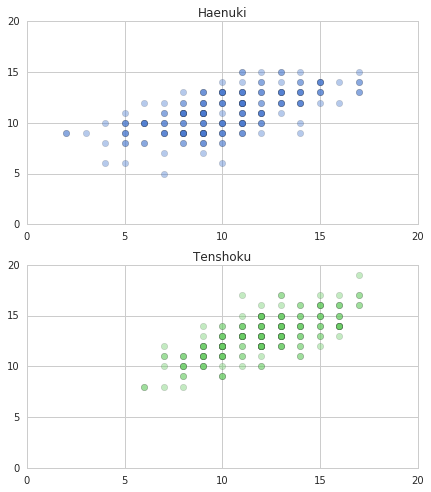

In [47]:
# 散布図で表示して元データを確認する
plt.figure(figsize=(7,8))
ax = plt.subplot(211)
plt.scatter(xA[0,:],xA[1,:], alpha=0.4, s=40)
plt.title("Haenuki")
plt.xlim(0,20)
plt.ylim(0,20)

plt.subplot(212)
plt.scatter(xB[0,:],xB[1,:], c="g" ,alpha=0.4, s=40)
plt.title("Tenshoku")
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()

In [56]:
data = {"N":N, "xA":xA.T, "xB":xB.T}

In [51]:
stan_code = """
data{
    int<lower=0>  N; // head count
    vector[2] xA[N]; // A
    vector[2] xB[N]; // B
}
parameters{
    vector[2] muA;
    vector<lower=0>[2] sigmaA;
    real<lower=-1,upper=1> rhoA;
    vector[2] muB;
    vector<lower=0>[2] sigmaB;
    real<lower=-1,upper=1> rhoB;
}
transformed parameters{
    vector<lower=0>[2] sig2A;
    matrix[2,2] SigmaA;
    vector<lower=0>[2] sig2B;
    matrix[2,2] SigmaB;

    sig2A[1] <- pow(sigmaA[1],2);
    sig2A[2] <- pow(sigmaA[2],2);
    SigmaA[1,1] <- sig2A[1];
    SigmaA[2,2] <- sig2A[2];
    SigmaA[1,2] <- sigmaA[1]*sigmaA[2]*rhoA;
    SigmaA[2,1] <- sigmaA[1]*sigmaA[2]*rhoA;

    sig2B[1] <- pow(sigmaB[1],2);
    sig2B[2] <- pow(sigmaB[2],2);
    SigmaB[1,1] <- sig2B[1];
    SigmaB[2,2] <- sig2B[2];
    SigmaB[1,2] <- sigmaB[1]*sigmaB[2]*rhoB;
    SigmaB[2,1] <- sigmaB[1]*sigmaB[2]*rhoB;
}
model{
    for(i in 1:N){
        xA[i] ~ multi_normal(muA, SigmaA);
        xB[i] ~ multi_normal(muB, SigmaB);
    }
}
generated quantities{
    real delta_r;
    real delta_r_over;
    #real delta_r_over2;
    delta_r <- rhoB - rhoA;
    delta_r_over <- step(delta_r);
    #delta_r_over2 <- if_else(delta_r>0.1,1,0);
}
"""

In [52]:
# モデルのコンパイル
%time stm = StanModel(model_code=stan_code)

CPU times: user 1.66 s, sys: 2.2 s, total: 3.86 s
Wall time: 1min 6s


In [57]:
# サンプリング実行
n_itr    = 11000   # サンプル数
n_warmup = 1000    # バーンイン期間
chains   = 1       # チェーンの数
seed     = 71      # 乱数のシード

# サンプリングの実行
%time fit = stm.sampling(data=data, iter=n_itr, chains=chains, n_jobs=-1, seed=seed, warmup=n_warmup, algorithm="NUTS", verbose=False)


CPU times: user 1min 25s, sys: 20 ms, total: 1min 25s
Wall time: 1min 25s


In [60]:
la    = fit.extract(permuted=True)  # return a dictionary of arrays
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])
print(fit)

Inference for Stan model: anon_model_e223a066fde24b8e6224e509977c3266.
1 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
muA[0]        10.04  4.2e-3   0.22    9.6    9.9  10.04  10.19  10.46   2698    1.0
muA[1]         11.0  2.8e-3   0.14  10.71   10.9   11.0   11.1  11.27   2688    1.0
sigmaA[0]      3.05  2.8e-3   0.15   2.77   2.95   3.05   3.15   3.37   2991    1.0
sigmaA[1]      2.04  1.9e-3    0.1   1.85   1.97   2.04   2.11   2.25   2932    1.0
rhoA           0.63  8.1e-4   0.04   0.54    0.6   0.63   0.66   0.71   2876    1.0
muB[0]        11.94  3.4e-3   0.18   11.6  11.82  11.94  12.07   12.3   2721    1.0
muB[1]        12.99  2.8e-3   0.15   12.7  12.89  12.99  13.08  13.27   2747    1.0
sigmaB[0]      2.51  2.5e-3   0.13   2.28   2.42   2.51    2.6   2.77   2641    1.0
sigmaB[1]      2.04  2.0e-3    0.1   1.85   1.97   2

In [63]:
print(fit.flatnames)

['muA[0]', 'muA[1]', 'sigmaA[0]', 'sigmaA[1]', 'rhoA', 'muB[0]', 'muB[1]', 'sigmaB[0]', 'sigmaB[1]', 'rhoB', 'sig2A[0]', 'sig2A[1]', 'SigmaA[0,0]', 'SigmaA[1,0]', 'SigmaA[0,1]', 'SigmaA[1,1]', 'sig2B[0]', 'sig2B[1]', 'SigmaB[0,0]', 'SigmaB[1,0]', 'SigmaB[0,1]', 'SigmaB[1,1]', 'delta_r', 'delta_r_over']


/mnt/workspace/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


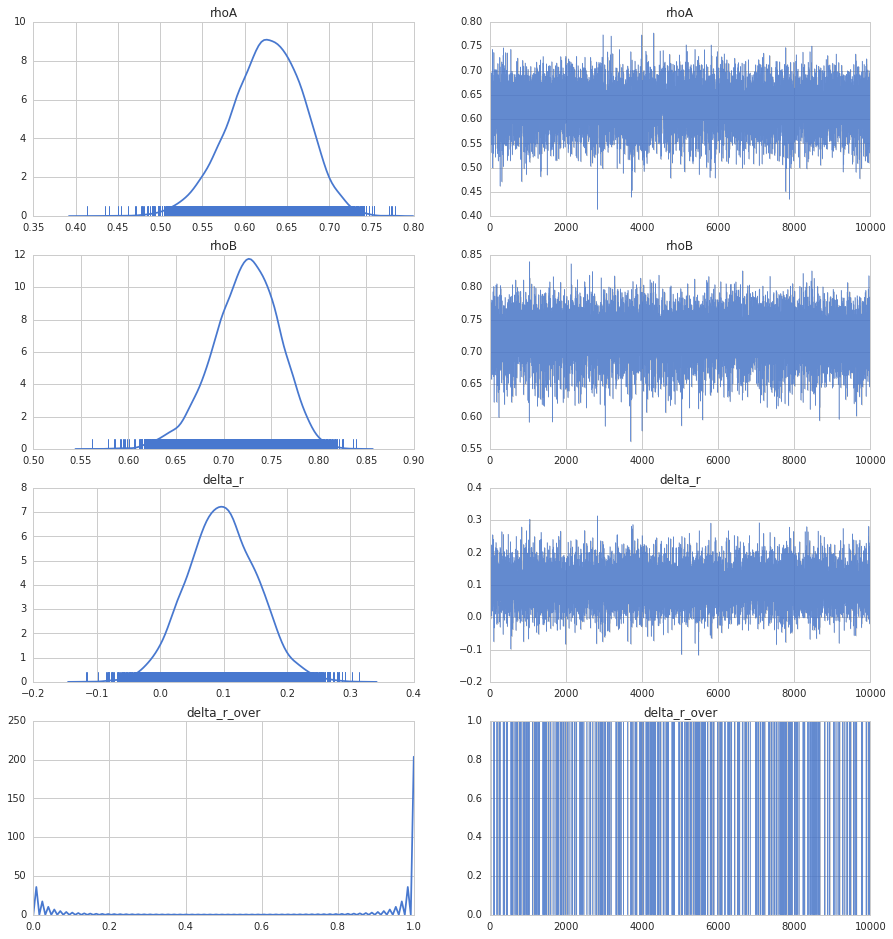

CPU times: user 2min 12s, sys: 3.01 s, total: 2min 15s
Wall time: 2min 15s


In [64]:
disp_param = ['rhoA','rhoB','delta_r','delta_r_over']
%time plot_result(disp_param, la)

In [67]:
Counter(la['delta_r_over'])

Counter({0.0: 378, 1.0: 9622})

In [ ]:
pd.DataFrame(fit.get_posterior_mean(), index=fit.flatnames+["lp__"], columns=["EAP"])

### 8.3 対応のある相関係数の差に関する推測

In [73]:
N = 165
x = np.array([
    [14,8,15,15,8,11,7,13,5,14,13,10,18,12,11,19,15,9,11,10,3,13,9,7,6,16,14,14,10,9,6,9,13,16,20,16,19,5,14,
     15,13,11,17,5,11,8,15,2,16,12,14,8,16,15,7,19,11,13,3,7,14,6,9,11,7,10,23,12,12,16,17,20,14,13,12,15,5,
     14,7,13,12,18,12,19,18,11,12,16,10,9,7,13,12,11,12,9,8,11,21,14,17,8,14,9,14,15,12,8,16,14,16,14,13,10,
     11,7,11,5,19,10,8,9,10,13,11,15,14,6,14,12,12,11,16,21,10,10,10,9,10,17,8,8,10,13,12,14,13,14,24,17,12,
     10,13,14,7,19,13,9,13,13,8,11,5,11,14],
    [12,8,23,13,8,11,11,13,13,15,16,15,18,9,20,12,19,10,17,12,11,10,16,16,7,9,16,14,14,11,10,12,18,16,17,13,
     14,1,12,15,12,5,14,13,14,16,15,3,17,9,11,15,16,20,4,11,11,17,8,15,8,15,7,13,8,7,17,12,13,14,15,21,14,15,
     13,12,9,16,12,8,17,12,11,14,10,18,11,15,10,11,14,20,9,6,8,5,16,13,19,13,22,9,13,8,12,25,16,17,16,13,11,
     13,14,17,14,9,15,10,19,7,12,10,17,11,8,18,11,10,9,5,16,13,21,14,16,16,15,13,20,11,7,11,7,13,16,12,17,17,
     22,14,16,9,16,12,13,14,15,12,15,16,11,9,5,12,11],
    [19,8,25,21,12,12,13,16,15,20,19,17,20,13,23,20,22,15,21,14,12,16,15,19,14,21,17,21,17,12,13,18,20,20,20,
     15,20,5,15,20,15,16,18,14,16,13,18,9,22,15,15,12,21,21,9,15,13,20,9,16,14,17,12,18,8,10,24,18,16,23,20,19,
     15,16,18,17,5,12,14,13,19,16,15,18,18,15,18,17,17,13,15,18,17,12,16,11,17,17,24,19,22,9,15,14,16,27,17,17,
     21,15,10,17,13,18,16,8,14,11,19,11,10,12,17,11,16,21,14,16,17,10,18,15,25,21,19,18,18,13,24,14,13,15,12,
     12,19,14,18,19,25,19,15,12,16,16,17,18,13,13,15,16,14,12,8,11,17]])
x = x.T
print(x.shape)

data = {"N":N, "x":x}

(165, 3)


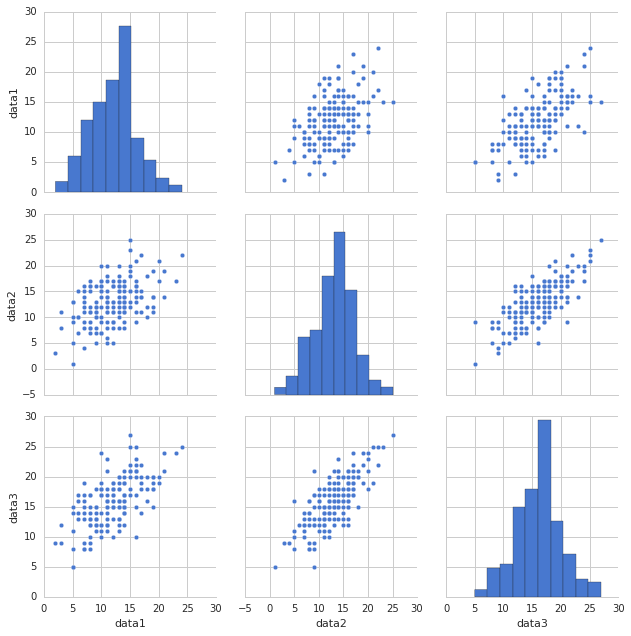

In [89]:
df_x = pd.DataFrame(x, columns=['data1','data2','data3'])
sns.pairplot(df_x,size=3)

In [93]:
stan_code ="""
data{
    int<lower=0>  N; // head count
    vector[3] x[N];
}
parameters{
    vector[3] mu;
    vector<lower=0>[3] sigma;
    corr_matrix[3] rho;
}
transformed parameters{
    vector<lower=0>[3] sig2;
    matrix[3,3] Sigma;
    /*
    sig2[1] <- pow(sigma[1],2);
    sig2[2] <- pow(sigma[2],2);
    sig2[3] <- pow(sigma[3],2);
    Sigma[1,1] <- sig2[1];
    Sigma[2,2] <- sig2[2];
    Sigma[3,3] <- sig2[3];
    Sigma[2,1] <- sigma[2]*sigma[1]*rho[2,1];
    Sigma[3,1] <- sigma[3]*sigma[1]*rho[3,1];
    Sigma[3,2] <- sigma[3]*sigma[2]*rho[3,2];
    */
    for(i in 1:3){
        sig2[i] <- pow(sigma[i],2);
    }
    Sigma <- diag_matrix(sigma) * rho * diag_matrix(sigma);
}
model{
    for(i in 1:N){
        x[i] ~ multi_normal(mu,Sigma);
    }
}
generated quantities{
    real delta_r2;
    real delta_r2_over;
    real rho_21;
    real rho_31;
    real rho_32;
    
    rho_21 <- rho[2,1];
    rho_31 <- rho[3,1];
    rho_32 <- rho[3,2];
    delta_r2 <- rho[3,2] - rho[2,1];
    delta_r2_over <- step(delta_r2);
}
"""

In [94]:
# モデルのコンパイル
%time stm = StanModel(model_code=stan_code)

CPU times: user 1.58 s, sys: 1.81 s, total: 3.39 s
Wall time: 1min 11s


In [95]:

n_itr    = 11000   # サンプル数
n_warmup = 1000    # バーンイン期間
chains   = 1       # チェーンの数
seed     = 71      # 乱数のシード

# サンプリングの実行
%time fit = stm.sampling(data=data, iter=n_itr, chains=chains, n_jobs=-1, seed=seed, warmup=n_warmup, algorithm="NUTS", verbose=False)


CPU times: user 44.4 s, sys: 12 ms, total: 44.4 s
Wall time: 44.2 s


In [96]:
la    = fit.extract(permuted=True)  # return a dictionary of arrays
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])
print(fit)

Inference for Stan model: anon_model_f57de59f3b50e9035ac7fae7f26501e9.
1 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]          12.03  6.7e-3   0.32   11.4  11.82  12.03  12.25  12.67   2283    1.0
mu[1]          12.98  6.8e-3   0.32  12.36  12.76  12.98  13.19  13.61   2246    1.0
mu[2]           16.0  6.9e-3   0.32  15.38  15.79   16.0  16.22  16.62   2145    1.0
sigma[0]        4.08  4.5e-3   0.23   3.68   3.92   4.07   4.23   4.55   2506    1.0
sigma[1]        4.11  4.7e-3   0.23   3.69   3.95    4.1   4.26   4.59   2409    1.0
sigma[2]        4.06  4.8e-3   0.23   3.64    3.9   4.05    4.2   4.53   2230    1.0
rho[0,0]         1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0  10000    nan
rho[1,0]        0.45  1.3e-3   0.06   0.33   0.41   0.45   0.49   0.57   2358    1.0
rho[2,0]        0.62  9.7e-4   0.05   0.52 

In [97]:
print(fit.flatnames)

['mu[0]', 'mu[1]', 'mu[2]', 'sigma[0]', 'sigma[1]', 'sigma[2]', 'rho[0,0]', 'rho[1,0]', 'rho[2,0]', 'rho[0,1]', 'rho[1,1]', 'rho[2,1]', 'rho[0,2]', 'rho[1,2]', 'rho[2,2]', 'sig2[0]', 'sig2[1]', 'sig2[2]', 'Sigma[0,0]', 'Sigma[1,0]', 'Sigma[2,0]', 'Sigma[0,1]', 'Sigma[1,1]', 'Sigma[2,1]', 'Sigma[0,2]', 'Sigma[1,2]', 'Sigma[2,2]', 'delta_r2', 'delta_r2_over', 'rho_21', 'rho_31', 'rho_32']


/mnt/workspace/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


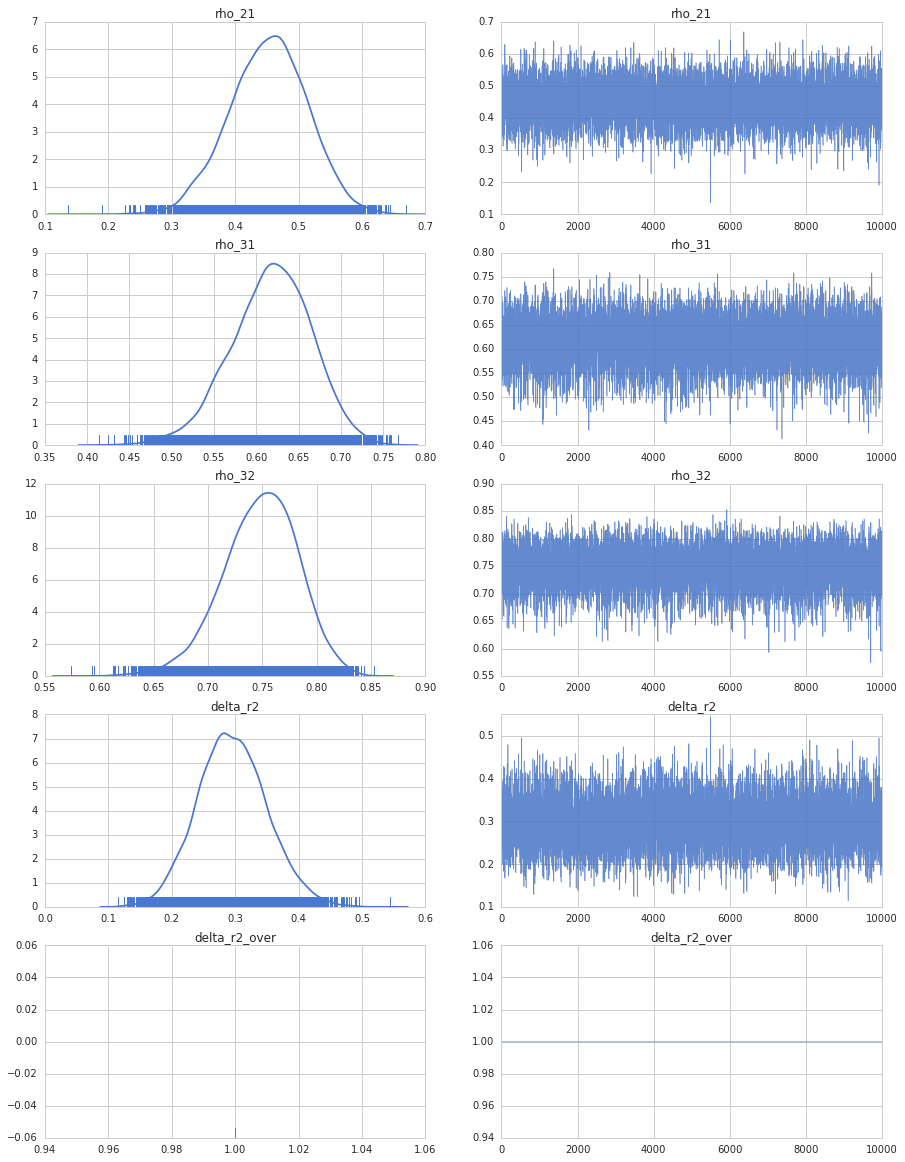

CPU times: user 2min 41s, sys: 3.74 s, total: 2min 45s
Wall time: 2min 45s


In [100]:
disp_param = ['rho_21', 'rho_31', 'rho_32', 'delta_r2', 'delta_r2_over']
%time plot_result(disp_param, la)

### 8.4 切断データの相関係数に関する推測

In [113]:
Ny = 122
y =np.array([
[102.03,100.021,106.896,101.377,106.666,106.856,106.283,102.021,121.985,100.569,121.94,112.031,
 108.223,112.76,113.05,100.746,101.025,106.245,103.151,100.201,112.689,111.177,103.05,103.505,
 106.19,107.896,102.991,114.977,118.362,106.395,109.559,107.448,106.31,104.488,115.524,109.301,
 103.69,103.085,110.463,120.259,105.924,101.278,104.557,107.144,103.712,103.082,103.68,100.827,
 108.754,113.234,103.457,116.65,109.066,109.126,105.76,100.83,105.764,101.726,119.707,114.521,
 121.871,120.465,100.403,105.934,105.717,102.085,113.606,102.805,107.159,110.142,111.876,109.786,
 107.352,104.63,102.26,120.779,105.601,102.545,105.16,120.547,128.796,113.891,108.876,139.733,
 108.256,126.098,103.926,102.735,112.503,101.49,133.44,116.673,100.689,116.804,101.775,106.207,
 107.46,103.507,115.666,111.644,103.767,100.883,105.852,112.799,100.046,122.549,107.527,104.543,
 110.155,103.333,108.286,102.216,101.855,102.281,102.844,115.864,112.526,130.022,100.223,106.315,103.711,103.586],
[98.045,96.033,123.283,107.59,107.208,129.971,115.929,114.757,136.362,104.839,121.687,120.007,
 99.866,109.329,128.378,124.048,103.538,109.645,97.872,103.528,109.151,112.933,115.748,104.311,
 94.237,103.437,104.498,105.271,126.66,105.026,100.875,98.136,92.122,100.075,123.251,104.811,
 105.385,115.617,116.049,108.832,110.559,108.036,99.25,113.701,123.181,119.613,96.444,103.741,
 119.377,101.273,103.408,121.15,106.866,91.142,98.812,105.474,101.994,117.242,108.987,107.522,
 108.948,139.479,117.521,87.594,98.026,110.909,99.027,117.408,114.01,114.542,112.761,141.939,
 111.53,101.998,95.751,133.996,99.954,115.285,125.597,140.997,151.571,96.12,126.341,141.881,112.872,
 129.171,91.797,115.774,125.598,101.204,129.889,122.54,94.311,121.264,106.921,103.722,118.718,95.837,
 102.577,116.035,108.877,104.545,116.468,118.603,83.394,125.9,108.083,109.303,116.327,101.569,103.356,
 110.803,89.975,99.76,90.28,110.885,109.124,128.54,104.989,101.649,106.036,103.044]])
y = y.T

Nx = 378
x = np.array([92.778,90.763,74.895,76.563,75.780,92.271,97.853,59.926,68.232,87.168,
    60.679,74.210,89.044,92.398,87.633,76.967,76.990,94.375,79.749,86.290,
    71.310,86.656,76.314,78.337,87.572,86.835,88.984,83.555,78.106,99.594,
    99.716,80.663,95.969,99.625,97.966,93.259,69.623,76.253,93.938,69.489,
    89.165,99.260,94.149,93.719,98.537,87.032,53.840,75.218,80.128,82.080,
    82.379,88.441,64.408,94.629,88.054,95.910,85.205,68.454,78.671,99.460,
    90.085,89.524,81.598,82.478,89.078,94.710,64.879,82.871,72.201,80.694,
    73.904,85.503,71.085,96.748,92.722,77.958,97.553,87.382,78.393,86.604,
    69.770,70.804,88.473,83.499,88.485,78.401,98.552,83.416,65.192,80.918,
    99.396,87.640,77.840,85.153,75.668,79.775,78.551,90.625,78.581,70.315,
    83.341,87.583,97.940,92.793,77.938,80.397,91.404,87.997,92.891,57.937,
    84.740,94.407,65.642,59.948,83.795,80.806,93.000,80.847,83.315,97.992,
    85.633,73.850,79.639,67.908,90.344,73.529,85.575,78.586,87.641,76.970,
    83.496,96.088,76.913,97.156,98.623,76.815,70.484,64.720,79.551,65.658,
    92.738,86.001,90.032,74.692,80.337,62.195,66.800,79.262,97.051,91.678,
    67.839,71.227,79.439,99.128,75.480,90.311,98.196,76.827,90.413,87.625,
    78.881,83.516,88.184,99.990,76.814,94.771,70.086,78.324,64.240,81.577,
    99.636,71.225,93.568,83.717,78.368,88.001,94.336,47.721,90.196,83.774,
    80.972,92.054,89.718,70.808,97.040,93.830,88.374,86.363,84.294,99.765,
    71.703,88.205,73.283,94.325,90.334,92.049,80.537,75.480,56.570,84.485,
    83.926,71.004,97.441,75.607,81.497,88.923,94.228,64.545,68.394,98.694,
    75.382,94.511,67.752,80.254,74.560,85.621,81.654,87.404,86.412,85.358,
    95.977,83.134,93.554,95.142,72.880,86.519,84.832,93.384,76.187,98.590,
    84.146,89.214,92.090,96.433,95.684,99.829,96.165,88.995,82.328,97.483,
    97.997,73.627,84.399,97.789,95.837,70.280,87.186,94.825,89.206,82.598,
    85.393,98.309,87.955,73.365,91.212,91.387,52.977,87.733,76.999,87.194,
    93.908,74.644,87.032,86.300,67.797,69.811,90.160,82.706,82.227,85.116,
    72.651,78.353,96.654,98.919,85.477,83.603,81.339,59.270,79.932,63.814,
    76.123,75.678,80.842,75.515,93.870,80.323,89.415,74.626,98.940,89.783,
    99.285,71.001,82.427,82.465,82.367,54.786,82.480,74.680,70.487,95.574,
    65.716,66.636,88.876,81.173,89.905,97.424,95.053,79.831,80.962,84.730,
    81.272,86.522,65.581,97.475,56.827,82.475,91.686,81.038,64.362,93.628,
    78.931,95.370,94.726,81.443,88.405,75.052,93.349,96.183,84.029,99.298,
    81.080,94.341,98.725,87.596,85.528,72.957,95.857,84.570,97.017,92.284,
    90.596,76.659,90.674,90.360,98.316,75.047,89.856,91.460,86.320,95.374,
    97.514,72.316,92.819,93.323,69.564,92.292,76.374,61.263,80.604,93.053,
    76.563,62.843,92.798,93.469,86.351,77.873,72.567,88.382,70.631,79.970,
    78.422,84.151,92.806,82.597,81.430,89.800,88.327,86.549])
print(y.shape, x.shape)

data = {"Nx":Nx, "Ny":Ny, "y":y, "x":x}

(122, 2) (378,)


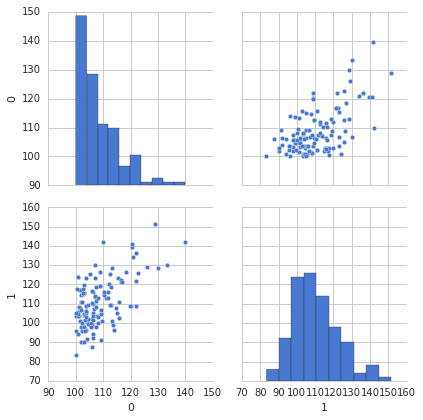

In [104]:
sns.pairplot(pd.DataFrame(y), size=3)

In [110]:
stan_code = """
# 8.4.1 and 8.4.2
data{
    int<lower=0> Ny;
    vector<lower=0>[2] y[Ny];
    int<lower=0> Nx;
    real x[Nx];
}
parameters{
    # 8.4.1
    vector[2] mu2;
    vector<lower=0>[2] sigma2;
    real sig2xy2;
    
    # 8.4.2
    vector[2] mu;
    vector<lower=0>[2] sigma;
    real sig2xy;
}
transformed parameters{
    # 8.4.1
    matrix[2,2] S2;
    vector[2] sigsq2;
    
    # 8.4.2
    matrix[2,2] Sigma;
    vector[2] sigsq;
    
    # 8.4.1
    sigsq2[1] <- sqrt(sigma2[1]);
    sigsq2[2] <- sqrt(sigma2[2]);
    S2[1,1]   <- sigma2[1];
    S2[2,2]   <- sigma2[2];
    S2[2,1]   <- sig2xy2;
    S2[1,2]   <- sig2xy2;
    
    # 8.4.2
    sigsq[1]   <- sqrt(sigma[1]);
    sigsq[2]   <- sqrt(sigma[2]);
    Sigma[1,1] <- sigma[1];
    Sigma[2,2] <- sigma[2];
    Sigma[2,1] <- sig2xy;
    Sigma[1,2] <- sig2xy;
}
model{
    # 8.4.1
    for(i in 1:Ny){
        y[i] ~ multi_normal(mu2, S2);
    }
    
    # 8.4.2
    for(i in 1:Ny){
        y[i] ~ multi_normal(mu, Sigma);
    }
    for(i in 1:Nx){
        x[i] ~ normal(mu[1], sqrt(sigma[1]));
    }
}
generated quantities{
    real<lower=-1,upper=1> rho_truncated; # Truncated Correlation
    real<lower=-1,upper=1> rho_corrected; # Corrected Truncated Correlation
    rho_truncated <- sig2xy2 / (sigsq2[1] * sigsq2[2]);
    rho_corrected <- sig2xy  / (sigsq[1] * sigsq[2]);
}
"""

In [111]:
# モデルのコンパイル
%time stm = StanModel(model_code=stan_code)

CPU times: user 1.71 s, sys: 1.83 s, total: 3.54 s
Wall time: 1min 5s


In [114]:
n_itr    = 11000   # サンプル数
n_warmup = 1000    # バーンイン期間
chains   = 1       # チェーンの数
seed     = 71      # 乱数のシード

# サンプリングの実行
%time fit = stm.sampling(data=data, iter=n_itr, chains=chains, n_jobs=-1, seed=seed, warmup=n_warmup, algorithm="NUTS", verbose=False)


CPU times: user 3min 36s, sys: 24 ms, total: 3min 36s
Wall time: 3min 35s


In [115]:
la    = fit.extract(permuted=True)  # return a dictionary of arrays
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])
print(fit)

Inference for Stan model: anon_model_80e82ef3f39013b14385bc30564eac23.
1 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]          89.77    0.01   0.64  88.51  89.33  89.77   90.2  90.99   3083    1.0
mu[1]          91.93    0.06    2.6  86.79  90.21  91.95  93.69  96.99   2098    1.0
sigma[0]      215.09    0.26  13.95 189.41 205.39 214.37 224.09  244.4   2886    1.0
sigma[1]      322.06    1.24   56.3  224.5 281.78 318.04 357.11 444.72   2045    1.0
sig2xy        213.62    0.66  29.73 157.72 192.97 213.32 233.36 272.53   2008    1.0
mu2[0]        108.63    0.01    0.7 107.26 108.17 108.64  109.1 109.99   2775    1.0
mu2[1]        110.66    0.02   1.16 108.38 109.87 110.66 111.44 112.91   2817    1.0
sigma2[0]      60.88    0.16   8.12  46.83  55.15   60.2  65.92  78.63   2633    1.0
sigma2[1]     167.31    0.42  22.01 129.35 

In [116]:
print(fit.flatnames)

['mu[0]', 'mu[1]', 'sigma[0]', 'sigma[1]', 'sig2xy', 'mu2[0]', 'mu2[1]', 'sigma2[0]', 'sigma2[1]', 'sig2xy2', 'Sigma[0,0]', 'Sigma[1,0]', 'Sigma[0,1]', 'Sigma[1,1]', 'sigsq[0]', 'sigsq[1]', 'S2[0,0]', 'S2[1,0]', 'S2[0,1]', 'S2[1,1]', 'sigsq2[0]', 'sigsq2[1]', 'rho_truncated', 'rho_corrected']


/mnt/workspace/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


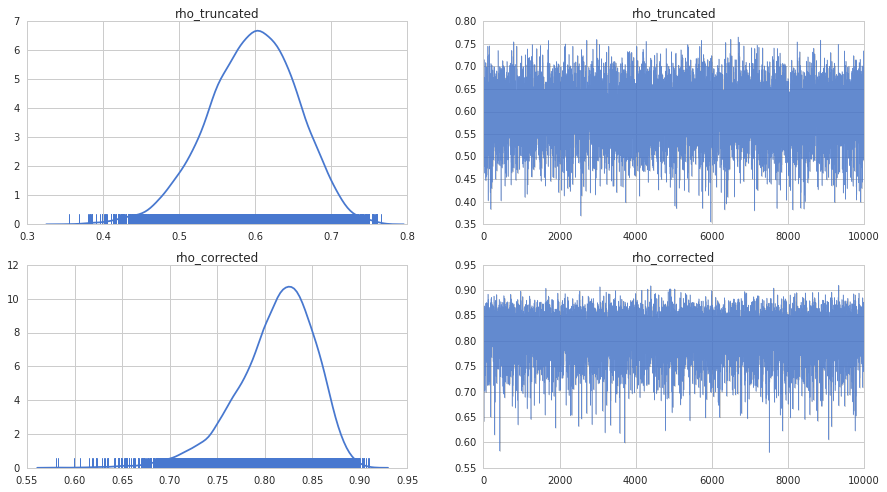

CPU times: user 59.9 s, sys: 1.97 s, total: 1min 1s
Wall time: 1min 1s


In [117]:
disp_param = ['rho_truncated','rho_corrected']
%time plot_result(disp_param, la)

In [163]:
Ny = 500
y  = np.array([
        [92.778,102.030,90.763,100.021,106.896,101.377,74.895,76.563,75.780,92.271,97.853,106.666,
         59.926,68.232,106.856,87.168,106.283,60.679,74.210,89.044,92.398,87.633,76.967,102.021,
         121.985,100.569,76.990,121.940,94.375,79.749,86.290,71.310,86.656,76.314,78.337,87.572,
         86.835,88.984,83.555,78.106,99.594,99.716,80.663,95.969,99.625,112.031,97.966,108.223,112.760,
         93.259,113.050,69.623,100.746,76.253,101.025,106.245,103.151,100.201,93.938,69.489,112.689,
         111.177,89.165,99.260,103.050,94.149,93.719,103.505,98.537,87.032,53.840,75.218,80.128,
         82.080,106.190,82.379,107.896,102.991,114.977,88.441,118.362,64.408,94.629,88.054,106.395,
         95.910,109.559,107.448,85.205,106.310,68.454,78.671,99.460,90.085,89.524,81.598,104.488,
         115.524,109.301,82.478,89.078,103.690,94.710,64.879,82.871,72.201,80.694,73.904,85.503,
         71.085,103.085,110.463,96.748,92.722,77.958,120.259,97.553,87.382,105.924,78.393,86.604,
         69.770,70.804,88.473,83.499,101.278,88.485,78.401,98.552,83.416,104.557,65.192,80.918,107.144,
         99.396,87.640,103.712,103.082,77.840,85.153,75.668,79.775,78.551,90.625,78.581,70.315,83.341,
         87.583,103.680,97.940,100.827,92.793,77.938,108.754,113.234,80.397,91.404,103.457,87.997,
         92.891,57.937,116.650,84.740,94.407,65.642,59.948,83.795,80.806,93.000,109.066,80.847,83.315,
         97.992,85.633,109.126,73.850,79.639,67.908,90.344,73.529,105.760,85.575,78.586,87.641,76.970,
         83.496,96.088,76.913,97.156,98.623,100.830,76.815,70.484,64.720,79.551,65.658,92.738,105.764,
         86.001,90.032,74.692,101.726,80.337,62.195,66.800,119.707,79.262,114.521,97.051,91.678,67.839,
         121.871,120.465,71.227,100.403,79.439,99.128,75.480,105.934,90.311,105.717,98.196,102.085,76.827,
         90.413,87.625,78.881,113.606,102.805,107.159,83.516,88.184,99.990,76.814,94.771,70.086,78.324,
         110.142,111.876,64.240,81.577,109.786,99.636,107.352,71.225,93.568,83.717,104.630,78.368,102.260,
         88.001,94.336,47.721,120.779,90.196,83.774,80.972,92.054,89.718,70.808,97.040,93.830,88.374,105.601,
         86.363,84.294,102.545,105.160,99.765,120.547,71.703,88.205,128.796,73.283,94.325,113.891,90.334,92.049,
         80.537,75.480,56.570,84.485,83.926,71.004,97.441,75.607,108.876,81.497,139.733,88.923,94.228,64.545,
         68.394,98.694,75.382,94.511,108.256,126.098,67.752,80.254,74.560,85.621,103.926,102.735,81.654,87.404,
         86.412,85.358,95.977,83.134,93.554,95.142,72.880,112.503,101.490,86.519,84.832,93.384,133.440,76.187,
         116.673,100.689,98.590,116.804,84.146,89.214,92.090,101.775,96.433,106.207,95.684,99.829,96.165,88.995,
         82.328,97.483,107.460,97.997,73.627,84.399,97.789,95.837,70.280,87.186,94.825,89.206,82.598,85.393,98.309,
         87.955,73.365,91.212,91.387,52.977,87.733,103.507,76.999,87.194,93.908,74.644,115.666,87.032,86.300,
         67.797,69.811,90.160,82.706,82.227,85.116,72.651,78.353,96.654,98.919,85.477,83.603,81.339,111.644,
         59.270,79.932,63.814,76.123,75.678,80.842,103.767,75.515,93.870,80.323,89.415,74.626,98.940,100.883,
         89.783,99.285,71.001,82.427,82.465,82.367,54.786,105.852,82.480,74.680,70.487,95.574,112.799,65.716,
         66.636,88.876,81.173,89.905,97.424,95.053,79.831,80.962,100.046,84.730,122.549,107.527,81.272,86.522,
         65.581,97.475,56.827,82.475,91.686,81.038,104.543,64.362,110.155,103.333,93.628,78.931,95.370,94.726,
         108.286,102.216,81.443,88.405,75.052,93.349,96.183,84.029,99.298,101.855,81.080,94.341,98.725,87.596,
         85.528,72.957,102.281,102.844,95.857,115.864,84.570,97.017,112.526,92.284,90.596,76.659,90.674,90.360,
         98.316,75.047,89.856,91.460,86.320,95.374,97.514,72.316,92.819,130.022,93.323,69.564,100.223,92.292,
         76.374,61.263,106.315,80.604,93.053,76.563,62.843,92.798,93.469,103.711,86.351,77.873,72.567,88.382,
         70.631,79.970,78.422,84.151,92.806,103.586,82.597,81.430,89.800,88.327,86.549],
        [97.676,98.045,95.871,96.033,123.283,107.590,76.922,87.652,73.718,88.481,94.810,107.208,41.117,67.894,129.971,
         96.891,115.929,55.238,80.922,94.052,72.092,89.911,69.137,114.757,136.362,104.839,59.545,121.687,79.492,74.333,
         92.903,79.893,99.173,64.167,93.569,75.212,103.494,83.948,77.770,80.824,96.581,95.557,73.349,87.625,105.904,
         120.007,90.667,99.866,109.329,108.099,128.378,57.522,124.048,75.554,103.538,109.645,97.872,103.528,69.571,
         77.539,109.151,112.933,88.361,83.214,115.748,92.314,87.910,104.311,93.614,85.379,63.434,67.719,66.325,86.843,
         94.237,88.465,103.437,104.498,105.271,93.307,126.660,64.484,105.021,87.785,105.026,96.503,100.875,98.136,
         93.789,92.122,51.077,72.976,107.142,81.092,102.108,73.481,100.075,123.251,104.811,86.387,97.666,105.385,99.438,
         53.755,95.697,83.017,82.880,78.448,71.842,69.686,115.617,116.049,99.243,88.382,81.026,108.832,92.846,86.496,
         110.559,78.509,89.953,59.763,59.317,86.923,76.293,108.036,93.586,86.713,113.276,99.036,99.250,55.825,89.866,
         113.701,97.886,75.278,123.181,119.613,104.811,72.671,69.718,83.917,80.737,103.630,74.784,82.107,72.959,86.143,
         96.444,103.114,103.741,98.435,79.225,119.377,101.273,67.321,85.833,103.408,81.710,106.524,58.581,121.150,
         69.851,75.571,75.431,46.415,74.433,58.097,85.048,106.866,104.886,84.693,95.451,82.745,91.142,89.247,77.490,
         95.104,79.747,72.985,98.812,84.137,85.908,84.344,64.055,88.339,97.844,81.916,106.434,85.353,105.474,83.363,
         39.569,71.382,87.465,54.836,91.046,101.994,78.268,84.984,74.235,117.242,79.119,59.444,59.448,108.987,86.511,
         107.522,98.383,81.782,74.935,108.948,139.479,81.638,117.521,74.376,106.359,90.097,87.594,98.361,98.026,95.821,
         110.909,60.459,96.845,99.922,80.262,99.027,117.408,114.010,85.900,100.665,117.920,69.108,93.173,80.245,82.906,
         114.542,112.761,84.417,72.991,141.939,102.308,111.530,70.014,83.666,83.392,101.998,90.170,95.751,86.940,91.716,
         43.590,133.996,100.489,80.224,81.255,100.318,78.955,70.584,97.555,106.718,79.110,99.954,90.156,47.095,115.285,
         125.597,104.878,140.997,75.974,83.457,151.571,75.026,83.570,96.120,104.926,100.962,99.238,64.935,52.933,93.270,
         63.788,68.445,97.043,54.338,126.341,66.641,141.881,83.117,87.800,52.875,62.150,90.712,68.790,76.158,112.872,
         129.171,82.632,98.250,75.280,95.420,91.797,115.774,71.308,74.944,102.034,89.857,103.445,90.456,81.074,106.213,
         69.171,125.598,101.204,78.561,88.669,85.003,129.889,81.514,122.540,94.311,100.007,121.264,69.036,100.547,103.360,
         106.921,105.517,103.722,96.066,116.874,93.791,88.687,80.885,100.061,118.718,87.674,66.351,66.903,85.995,91.009,
         97.365,90.950,96.927,98.694,89.123,80.448,112.377,71.197,81.300,86.219,83.932,54.598,83.110,95.837,67.429,
         101.167,85.134,88.028,102.577,85.113,69.759,81.660,69.063,88.411,58.856,73.889,73.920,71.392,80.757,102.168,
         85.425,70.174,82.717,61.509,116.035,44.832,80.540,64.345,70.656,59.220,80.643,108.877,90.712,99.155,69.584,97.424,
         65.156,88.923,104.545,92.690,110.352,73.568,91.430,94.075,88.491,61.591,116.468,84.839,80.622,57.104,106.756,
         118.603,68.179,77.663,82.322,82.690,78.932,85.014,104.745,80.862,74.679,83.394,82.868,125.900,108.083,84.067,
         90.777,90.952,102.226,40.108,82.289,97.820,70.375,109.303,62.165,116.327,101.569,90.913,89.055,74.531,92.108,
         103.356,110.803,92.965,93.104,83.707,87.397,100.938,91.164,82.863,89.975,80.646,87.212,84.286,79.338,96.420,
         69.359,99.760,90.280,105.277,110.885,87.870,99.511,109.124,75.705,85.605,80.672,96.589,100.311,104.453,70.570,
         95.717,98.975,93.805,86.228,78.143,72.914,101.056,128.540,81.968,56.782,104.989,86.915,59.130,62.566,101.649,
         72.857,97.271,70.226,93.843,90.985,78.631,106.036,79.806,98.018,74.025,96.699,60.566,83.365,73.452,74.688,90.561,
         103.044,94.328,95.290,98.348,94.105,95.489]])
y = y.T
y.shape

(500, 2)

In [172]:
ok = []
ng = []
for y1, y2 in y:
    if y1 < 100:
        ng.append([y1, y2])
    else:
        ok.append([y1, y2])
ok = np.array(ok)
ng = np.array(ng)

(20, 160)

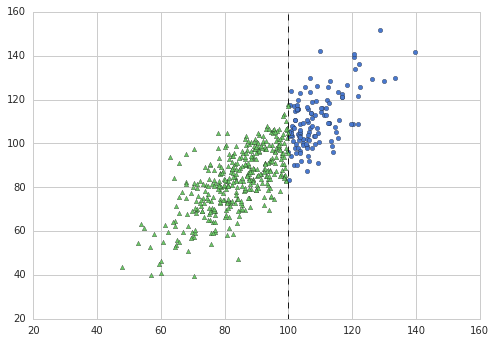

In [178]:
#plt.scatter(y[:,0],y[:,1],)

plt.scatter(ok[:,0],ok[:,1], marker="o", c="b")
plt.scatter(ng[:,0],ng[:,1], marker="^", c="g")
plt.plot([100,100], [0,200], "k--", lw=1)
plt.xlim(20,160)
plt.ylim(20,160)

In [166]:
data = {"Ny":Ny, "y":y}

In [167]:
stan_code = """
data{
    int<lower=0> Ny;
    vector<lower=0>[2] y[Ny];
}
parameters{
    vector[2] mu3;
    vector<lower=0>[2] sigma3;
    real sig2xy3;
}
transformed parameters{
    matrix[2,2] S3;
    vector[2] sigsq3;
    sigsq3[1] <- sqrt(sigma3[1]);
    sigsq3[2] <- sqrt(sigma3[2]);
    S3[1,1] <- sigma3[1];
    S3[2,2] <- sigma3[2];
    S3[2,1] <- sig2xy3;
    S3[1,2] <- sig2xy3;
}
model{
    for(i in 1:Ny){
        y[i] ~ multi_normal(mu3, S3);
    }
}
generated quantities{
    real<lower=-1,upper=1> rho_complete;
    rho_complete <- sig2xy3 / (sigsq3[1] * sigsq3[2]);
}
"""

In [168]:
# モデルのコンパイル
%time stm = StanModel(model_code=stan_code)

CPU times: user 1.66 s, sys: 3.02 s, total: 4.68 s
Wall time: 1min 6s


In [169]:
n_itr    = 11000   # サンプル数
n_warmup = 1000    # バーンイン期間
chains   = 1       # チェーンの数
seed     = 71      # 乱数のシード

# サンプリングの実行
%time fit = stm.sampling(data=data, iter=n_itr, chains=chains, n_jobs=-1, seed=seed, warmup=n_warmup, algorithm="NUTS", verbose=False)


CPU times: user 4min 16s, sys: 60 ms, total: 4min 16s
Wall time: 4min 15s


In [170]:
la    = fit.extract(permuted=True)  # return a dictionary of arrays
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])
print(fit)

Inference for Stan model: anon_model_c2c883628676a3ad8428eb198b11b9a1.
1 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu3[0]         89.8    0.02   0.65   88.5  89.36  89.81  90.24  91.05   1848    1.0
mu3[1]        89.97    0.02   0.81  88.34  89.44  89.98  90.52  91.54   1857    1.0
sigma3[0]    215.03    0.33  13.87 189.07 205.58 214.72 223.95 243.66   1817    1.0
sigma3[1]    337.55    0.51  21.78 297.72 322.38 336.43 351.92 382.81   1816    1.0
sig2xy3      223.48    0.39  15.98 194.26 212.25 223.06 234.04 256.11   1705    1.0
S3[0,0]      215.03    0.33  13.87 189.07 205.58 214.72 223.95 243.66   1817    1.0
S3[1,0]      223.48    0.39  15.98 194.26 212.25 223.06 234.04 256.11   1705    1.0
S3[0,1]      223.48    0.39  15.98 194.26 212.25 223.06 234.04 256.11   1705    1.0
S3[1,1]      337.55    0.51  21.78 297.72 322.38 336

/mnt/workspace/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


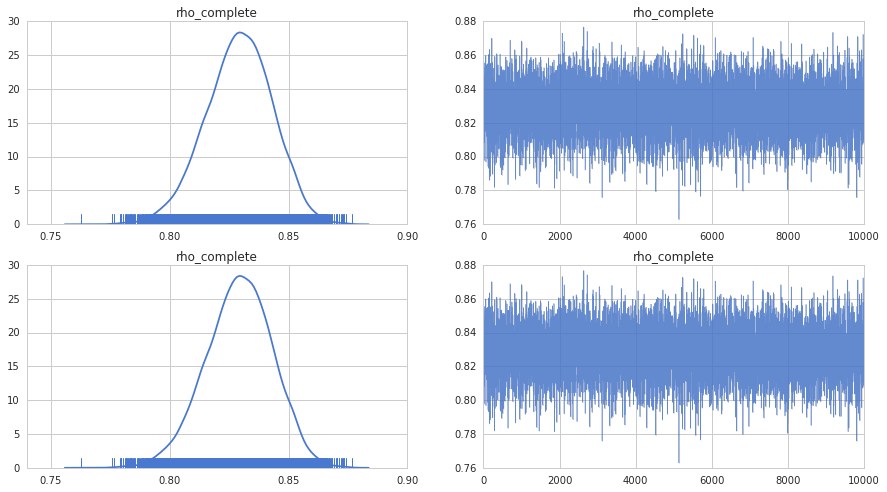

CPU times: user 1min, sys: 1.79 s, total: 1min 1s
Wall time: 1min 1s


In [180]:
disp_param = ['rho_complete','rho_complete']
%time plot_result(disp_param, la)

### 8.5 級内相関

In [148]:
score = np.array([[3,6,7,0],
        [10,10,8,8],
        [10,9,10,9],
        [1,2,4,2],
        [8,8,8,14],
        [10,9,9,11],
        [5,4,8,5],
        [7,5,9,6],
        [5,6,4,5],
        [2,3,5,5],
        [10,5,5,7],
        [4,4,3,3],
        [5,5,3,5],
        [6,6,8,10],
        [14,9,14,9]])
S, R = score.shape
S, R

(15, 4)

In [149]:
data = {"S":S, "R":R, "Score":score}

In [150]:
stan_code = """
# Random effect model
data{
    int<lower=0> S;
    int<lower=0> R;
    vector<lower=0, upper=15>[R] Score[S];
}
parameters{
    real mu;
    real alpha[S];
    real beta[R];
    real<lower=0> tauSubject;
    real<lower=0> tauRater;
    real<lower=0> tauWithin;
}
transformed parameters{
    real<lower=0> sig2subject;
    real<lower=0> sig2rater;
    real<lower=0> sig2within;
    sig2subject <- pow(tauSubject,2);
    sig2rater <- pow(tauRater,2);
    sig2within <- pow(tauWithin,2);
}
model{
    real nu;
    mu ~ normal(0, 1000);
    for(s in 1:S){
        alpha[s] ~ normal(0, tauSubject);
    }
    for(r in 1:R){
        beta[r] ~ normal(0, tauRater);
    }
    for(s in 1:S) {
        for(r in 1:R) {
            nu <- mu + alpha[s] + beta[r];
            Score[s,r] ~ normal(nu, tauWithin);
        }
    }
}
generated quantities{
    real<lower=0> ICC21;
    real<lower=0> ICC24;
    real<lower=0> rho5;
    real<lower=0> rho6;
    real nine6;
    ICC21 <- sig2subject / (sig2subject + sig2rater + sig2within);
    ICC24 <- sig2subject / (sig2subject + ((sig2rater + sig2within)/4));
    rho5  <- sig2subject / (sig2subject + ((sig2rater + sig2within)/5));
    rho6  <- sig2subject / (sig2subject + ((sig2rater + sig2within)/6));
    nine6 <- step(rho6 - 0.9);
}
"""

In [151]:
# モデルのコンパイル
%time stm = StanModel(model_code=stan_code)

CPU times: user 1.7 s, sys: 1.87 s, total: 3.57 s
Wall time: 59.7 s


In [152]:
n_itr    = 50000   # サンプル数
n_warmup = 15000    # バーンイン期間
chains   = 1       # チェーンの数
seed     = 71      # 乱数のシード

# サンプリングの実行
%time fit = stm.sampling(data=data, iter=n_itr, chains=chains, n_jobs=-1, seed=seed, warmup=n_warmup, algorithm="NUTS", verbose=False)


CPU times: user 9.98 s, sys: 44 ms, total: 10 s
Wall time: 9.98 s


In [153]:
la    = fit.extract(permuted=True)  # return a dictionary of arrays
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])
print(fit)

Inference for Stan model: anon_model_33b8a2cf58538dfb58d07373cba7a668.
1 chains, each with iter=50000; warmup=15000; thin=1; 
post-warmup draws per chain=35000, total post-warmup draws=35000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu            6.63    0.08   1.37   4.59   6.04    6.6    7.2   8.55    324    1.0
alpha[0]      -2.3    0.04   1.17  -4.57  -3.12   -2.3  -1.51  -0.03    963    1.0
alpha[1]      2.12    0.02   1.16  -0.12   1.33    2.1   2.89   4.43   3162    1.0
alpha[2]      2.56    0.04   1.18   0.34   1.76   2.55   3.35   4.88    720    1.0
alpha[3]     -3.85    0.03   1.18  -6.22  -4.59  -3.86  -3.06  -1.52   2045    1.0
alpha[4]      2.58    0.02   1.15   0.36   1.82   2.55   3.36   4.94   3478    1.0
alpha[5]      2.81    0.02   1.17   0.54   2.03   2.78   3.57   5.15   2344    1.0
alpha[6]     -0.97    0.03   1.16  -3.23  -1.77  -0.97  -0.21   1.33   1206    1.0
alpha[7]      0.14    0.03   1.16  -2.12  -0.67   0.13   0.9

/mnt/workspace/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


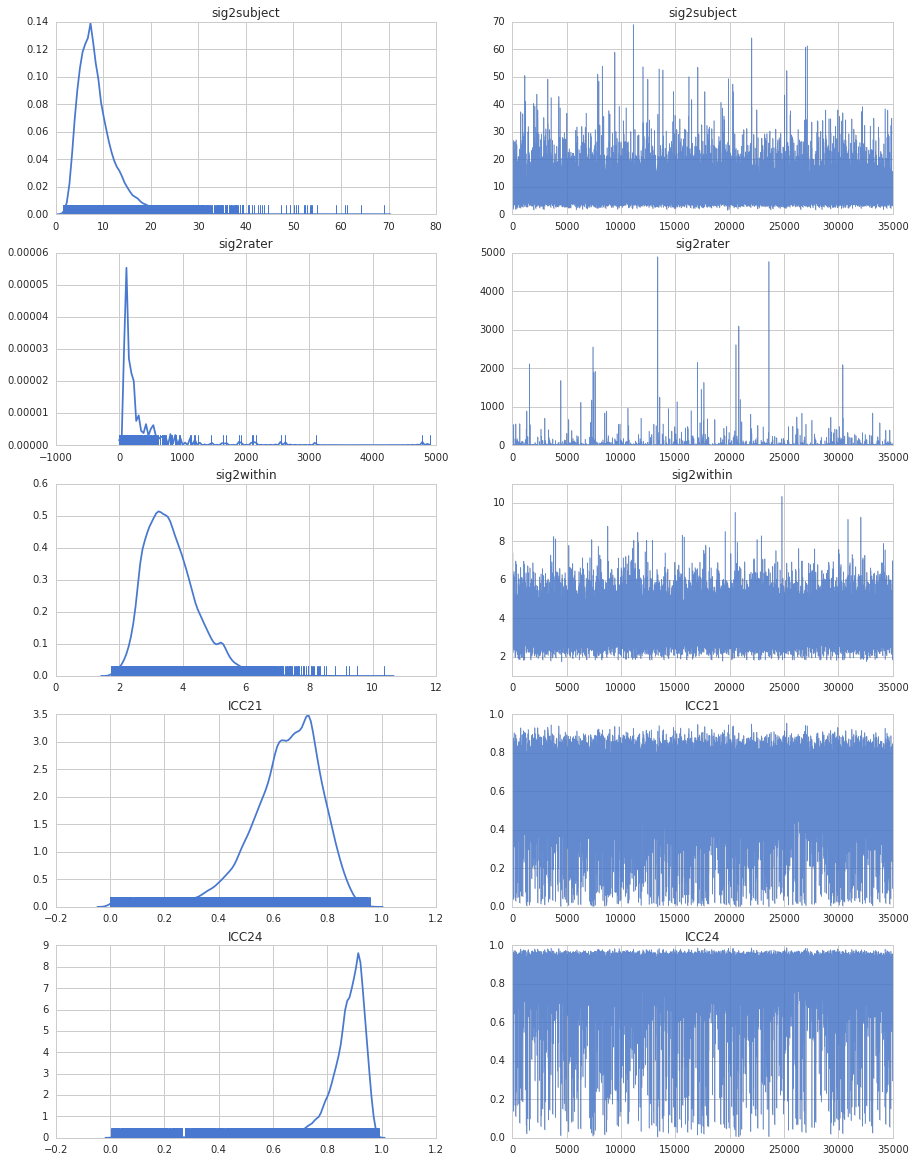

CPU times: user 9min 23s, sys: 20.8 s, total: 9min 43s
Wall time: 9min 43s


In [154]:
disp_param = ['sig2subject','sig2rater','sig2within','ICC21','ICC24']
%time plot_result(disp_param, la)

###### 混合効果モデル

In [155]:
stan_code = """
# mixed effect model
data{
    int<lower=0> S; # headcount of tested
    int<lower=0> R; # headcount of judger
    vector<lower=0, upper=15>[R] Score[S];
}
transformed data{
    int<lower=0> Rm1;
    Rm1 <- R-1;
}
parameters{
    real mu;
    real alpha[S];
    real beta_m1[Rm1];
    real<lower=0> tauSubject; # standard deviation for tested
    real<lower=0> tauWithin;
}
transformed parameters{
    real beta[R];
    real<lower=0> sig2subject;
    real<lower=0> sig2within;
    sig2subject <- pow(tauSubject,2);
    sig2within  <- pow(tauWithin,2);
    for (r in 1:Rm1) {
        beta[r] <- beta_m1[r];
    }
    beta[R] <- -sum(beta_m1);
}
model{
    real nu;
    mu ~ normal(0, 1000);
    for(s in 1:S){
        alpha[s] ~ normal(0, tauSubject);
    }
    for(s in 1:S) {
        for(r in 1:R) {
            nu <- mu + alpha[s] + beta[r];
            Score[s,r] ~ normal(nu, tauWithin);
        }
    }
}
generated quantities{
    real<lower=0> ICC31;
    real<lower=0> ICC34;
    real<lower=0> rho5;
    real<lower=0> rho6;
    real nine;
    ICC31 <- sig2subject / (sig2subject + sig2within); 
    ICC34 <- sig2subject / (sig2subject + (sig2within/R));
    rho5 <- sig2subject / (sig2subject + (sig2within/5));
    rho6 <- sig2subject / (sig2subject + (sig2within/6));
    nine <- step(rho5 - 0.9);
}
"""

In [156]:
# モデルのコンパイル
%time stm = StanModel(model_code=stan_code)

CPU times: user 1.77 s, sys: 3.12 s, total: 4.89 s
Wall time: 1min 1s


In [157]:
n_itr    = 50000   # サンプル数
n_warmup = 15000    # バーンイン期間
chains   = 1       # チェーンの数
seed     = 71      # 乱数のシード

# サンプリングの実行
%time fit = stm.sampling(data=data, iter=n_itr, chains=chains, n_jobs=-1, seed=seed, warmup=n_warmup, algorithm="NUTS", verbose=False)


CPU times: user 7.85 s, sys: 48 ms, total: 7.9 s
Wall time: 7.87 s


In [158]:
la    = fit.extract(permuted=True)  # return a dictionary of arrays
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])
print(fit)

Inference for Stan model: anon_model_52fbb6a844a901a98c3bb73d053d04d0.
1 chains, each with iter=50000; warmup=15000; thin=1; 
post-warmup draws per chain=35000, total post-warmup draws=35000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu            6.58    0.01    0.8   4.99   6.07   6.59    7.1   8.18   4075    1.0
alpha[0]     -2.29    0.01   1.17  -4.59  -3.07  -2.29   -1.5   0.02   6331    1.0
alpha[1]      2.15    0.01   1.17  -0.14   1.37   2.14   2.91   4.46   6464    1.0
alpha[2]      2.59    0.01   1.17   0.31   1.81   2.59   3.38   4.92   6550    1.0
alpha[3]     -3.84    0.01   1.19  -6.22  -4.62  -3.83  -3.05  -1.52   6709    1.0
alpha[4]      2.59    0.01   1.17   0.31   1.82   2.57   3.34   4.93   6331    1.0
alpha[5]      2.81    0.01   1.17   0.54   2.03    2.8   3.59   5.15   6509    1.0
alpha[6]     -0.96    0.01   1.16  -3.24  -1.73  -0.96   -0.2   1.33   6395    1.0
alpha[7]      0.14    0.01   1.16  -2.16  -0.63   0.15   0.9

/mnt/workspace/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


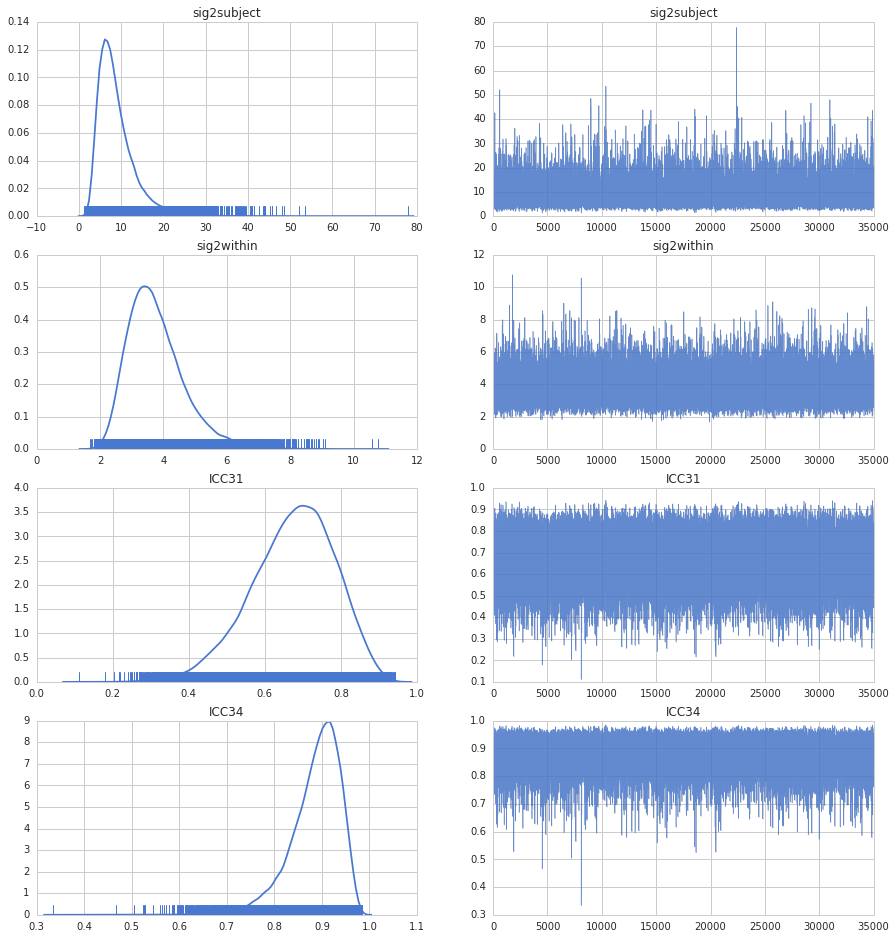

CPU times: user 7min 31s, sys: 16.5 s, total: 7min 47s
Wall time: 7min 47s


In [159]:
disp_param = ['sig2subject','sig2within','ICC31','ICC34']
%time plot_result(disp_param, la)